## 1 - Import Library

To start, we will import the required libraries:

In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

%matplotlib inline
np.random.seed(1)

# 2 - Building the neural network


### 2.0 - Problem statement: chewing sequence dataset

Run the following code to load the dataset.

In [2]:
# Loading the dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

Change the index below and run the cell to visualize some examples in the dataset.

y = 1


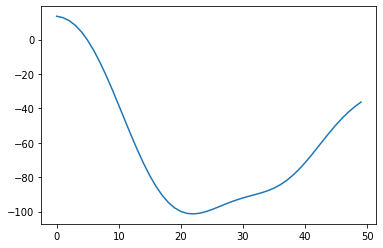

In [3]:
# Example of a signal
index = 0
plt.plot(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

We flatten the signal dataset and then normalize it. On top of that, we will convert each label to a one-hot vector. Run the cell below to do so.

In [4]:
# Flatten the training and test images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
# Normalize signal vectors
X_min = min(np.amin(X_train_flatten),np.amin(X_test_flatten))
X_max = max(np.amax(X_train_flatten),np.amax(X_test_flatten))
X_train = (X_train_flatten-X_min)/(X_max-X_min)
X_test = (X_test_flatten-X_min)/(X_max-X_min)
# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 2)
Y_test = convert_to_one_hot(Y_test_orig, 2)

print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 302
number of test examples = 130
X_train shape: (50, 302)
Y_train shape: (2, 302)
X_test shape: (50, 130)
Y_test shape: (2, 130)


**Note** that 50 comes from the length of segment.

**The model** is *LINEAR -> RELU -> LINEAR -> SOFTMAX*. The SIGMOID output layer has been converted to a SOFTMAX. A SOFTMAX layer generalizes SIGMOID to when there are more than two classes. 

### 2.1 - Create placeholders

The first task is to create placeholders for `X` and `Y`. This will allow us to later pass our training data in when we run our session. 

In [5]:
# GRADED FUNCTION: create_placeholders

def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an signal vector (50)
    n_y -- scalar, number of classes (from 0 to 1, so -> 2)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "tf.float32"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "tf.float32"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    X = tf.placeholder(shape = [n_x, None], dtype = tf.float32, name = 'X')
    Y = tf.placeholder(shape = [n_y, None], dtype = tf.float32, name = 'Y')
    
    return X, Y

### 2.2 - Initializing the parameters

We are going use Xavier Initialization for weights and Zero Initialization for biases.

In [6]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [10, 50]
                        b1 : [10, 1]
                        W2 : [2, 10]
                        b2 : [2, 1]

    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2
    """
    
    tf.compat.v1.set_random_seed(1)                   # so that your "random" numbers match ours
        
    W1 = tf.get_variable("W1", [10,50], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [10,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [2,10], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [2,1], initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

### 2.3 - Forward propagation in tensorflow 

We will now implement the forward propagation module in tensorflow.


In [7]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2"
                  the shapes are given in initialize_parameters

    Returns:
    Z2 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    Z1 = tf.add(tf.matmul(W1, X), b1)                    # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                   # Z2 = np.dot(W2, A1) + b2
    
    return Z2

### 2.4 Compute cost

Implementation of cost function.

In [8]:
# GRADED FUNCTION: compute_cost 

def compute_cost(Z2, Y):
    """
    Computes the cost
    
    Arguments:
    Z2 -- output of forward propagation (output of the last LINEAR unit), of shape (2, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z2
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z2)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    
    return cost

### 2.5 - Backward propagation, parameter updates & building the model

After implementing backward propagation and parameter updates, finally we can build the actual model

In [9]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 16, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 50, number of training examples = 302)
    Y_train -- test set, of shape (output size = 2, number of training examples = 302)
    X_test -- training set, of shape (input size = 50, number of training examples = 130)
    Y_test -- test set, of shape (output size = 2, number of test examples = 130)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z2 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z2, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict = {X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per fives)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z2), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

 Run the following cell to train our model! We can play with the hyperparametes and see how it gives change in the performance.

Cost after epoch 0: 0.837222
Cost after epoch 100: 0.613564
Cost after epoch 200: 0.473728
Cost after epoch 300: 0.354124
Cost after epoch 400: 0.268103
Cost after epoch 500: 0.210381
Cost after epoch 600: 0.171159
Cost after epoch 700: 0.143668
Cost after epoch 800: 0.124453
Cost after epoch 900: 0.110363
Cost after epoch 1000: 0.101228
Cost after epoch 1100: 0.092993
Cost after epoch 1200: 0.086952
Cost after epoch 1300: 0.081913
Cost after epoch 1400: 0.078674


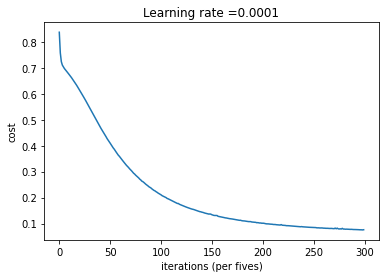

Parameters have been trained!
Train Accuracy: 0.9933775
Test Accuracy: 0.9153846


In [12]:
parameters = model(X_train, Y_train, X_test, Y_test)

Your algorithm predicts: y = 1


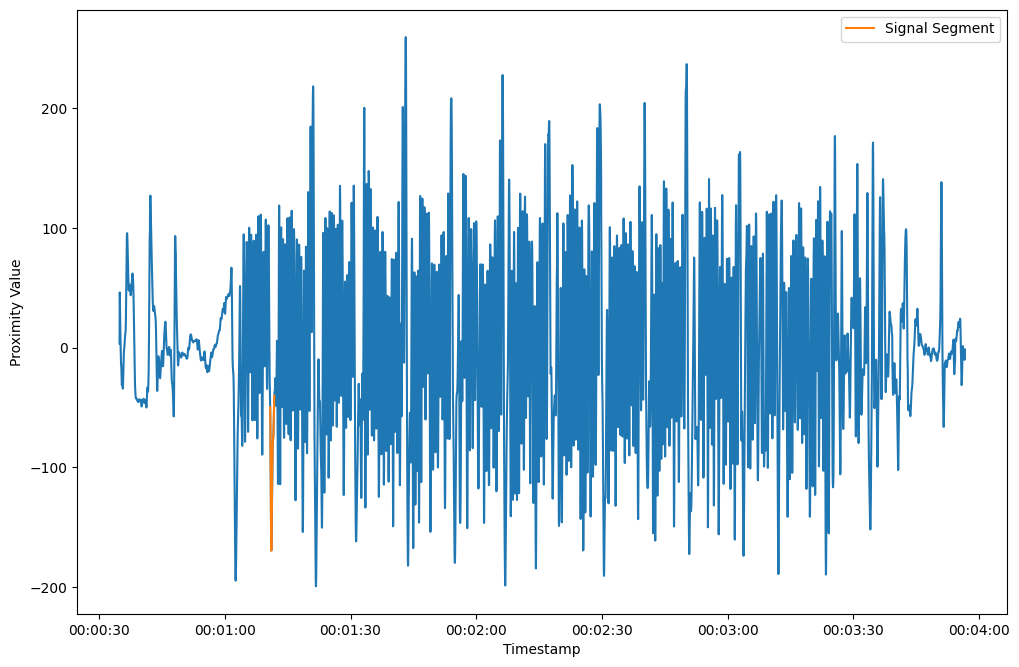

In [13]:
import pandas as pd

my_signal = "chewing_sequence.h5"
fname = "signal/" + my_signal
hdf = pd.HDFStore(fname)
my_signal = hdf.get('signal')['Proximity']

index = 1960  # change this to see prediction in different segments.
my_segment = my_signal.values[index:index+50].reshape((1, 50)).T
X_min = np.amin(my_signal.values)
X_max = np.amax(my_signal.values)
my_segment_norm = (my_segment-X_min)/(X_max-X_min)
timestamp = my_signal.index[index:index+50]

my_segment_prediction = predict(my_segment_norm, parameters)

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(my_signal.index,my_signal.values)
plt.plot(timestamp, my_segment, label='Signal Segment')
plt.xlabel('Timestamp')
plt.ylabel('Proximity Value')
plt.legend(loc='upper right')
print("Your algorithm predicts: y = " + str(np.squeeze(my_segment_prediction)))